In [8]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
df_initial = pd.read_csv('../data.csv')

In [9]:
def drop_records_brand_equal_model(df):
    """
    Entfernt alle Zeilen, in denen brand und model nach Normalisierung identisch sind.
    """
    def normalize(text):
        if pd.isna(text):
            return ""
        return re.sub(r"[^a-z0-9]", "", text.lower())

    df = df.copy()
    df["brand_norm"]  = df["brand"].apply(normalize)
    df["model_norm"]  = df["model"].apply(normalize)

    # Zeilen behalten, bei denen die Normalisierungen unterschiedlich sind
    df = df[df["brand_norm"] != df["model_norm"]].reset_index(drop=True)

    df.drop(columns=["brand_norm", "model_norm"], inplace=True)
    return df
#--------------------------------------   


    
# Daten laden
df = pd.read_csv('../data.csv')
    
# entferne Duplikate  
df = df.drop_duplicates(subset= ['brand', 'model', 'color', 'registration_date', 'year',
    'price_in_euro', 'power_kw', 'power_ps', 'transmission_type',
    'fuel_type', 'fuel_consumption_l_100km', 'fuel_consumption_g_km',
    'mileage_in_km', 'offer_description']) 

# Droppe zweite Index Spalte
if 'Unnamed: 0' in df.columns:
    df = df.drop('Unnamed: 0', axis=1)
'''
# andere fuel Types als Diesel und Petrol in einen anderen Datensatz extrakhieren    
valid_fuel_types = ['Hybrid', 'Diesel Hybrid', 'Electric', 'LPG', 'CNG', 'Ethanol', 'Hydrogen', 'Other']
df_before_filter = df.copy()    
df_other_fuel_types = df_before_filter[(~df_before_filter['fuel_type'].isin(['Diesel', 'Petrol'])) & (df_before_filter['fuel_type'].isin(valid_fuel_types))].reset_index(drop=True)
    # evtl. den ersten Teil  ~df_before_filter['fuel_type'].isin(['Diesel', 'Petrol'])) & rausnehmen? Denn ist ja doppelt, denn Bedingung wird ja in dem 2. Teil ja schon überpüft wird
'''   
df = df.loc[df['fuel_type'].isin(['Diesel', 'Petrol'])]
df = df.loc[df['fuel_consumption_g_km'].str.contains(r'g/km', na=False)] # hiermit werden hybride Fahrzeuge rausgefiltert (haben Reichweite in g/km drin, aber trotzdem fuel Type Petrol/ Diesel
df = df.reset_index(drop=True)

        
# Zeilen mit falschen Jahreszahlen werden herausgenommen
yearsToFilter = list(df['year'].unique()[:29])
filt = [val in yearsToFilter for val in df['year']]
df = df[filt]

def Electrics_Reichweite(df):
# Filtere die Zeilen, bei denen "fuel_type" = "Electric" und "fuel_consumption_g_km" das Wort "Reichweite" enthält
    e_mit_reichweite = (df["fuel_type"] == "Electric") & (df["fuel_consumption_g_km"].astype(str).str.contains("Reichweite", na=False))
    # Cutte in der Spalte "fuel_consumption_g_km" beim ersten Leerzeichen
    df.loc[e_mit_reichweite, "fuel_consumption_g_km"] = df.loc[e_mit_reichweite, "fuel_consumption_g_km"].astype(str).str.split().str[0]
    # Kopiere Werte von "fuel_consumption_g_km" in die Spalte "fuel_consumption_l_100km"
    df.loc[e_mit_reichweite, "fuel_consumption_l_100km"] = df.loc[e_mit_reichweite, "fuel_consumption_g_km"]
    
    return df

df = Electrics_Reichweite(df)
            
def clean_fuel_consumption(value): 
    if pd.isna(value) or 'l/100 km' not in str(value):
        return np.nan
    try:
        return float(value.split(' ')[0].replace(',', '.'))
    except:
        return np.nan
                    
def clean_fuel_consumption_g(value):
    if pd.isna(value) or value == '- (g/km)' or 'g/km' not in str(value): # Bei Elektroautos steht Reichweite
        return np.nan
    try:
        return float(value.split(' ')[0])
    except:
        return np.nan
                    
df['fuel_consumption_l_100km'] = df['fuel_consumption_l_100km'].apply(clean_fuel_consumption)
df['fuel_consumption_g_km'] = df['fuel_consumption_g_km'].apply(clean_fuel_consumption_g)      


# Funktion zur Berechnung fehlender l/100km Werte, wenn g/km gegeben ist
def calculate_fuel_consumption(row):

    conversion_factor = 0.043103448275862

    if pd.isna(row['fuel_consumption_l_100km']) or row['fuel_consumption_l_100km'] == 0:
        if pd.notna(row['fuel_consumption_g_km']) and row['fuel_consumption_g_km'] != 0:
            return row['fuel_consumption_g_km'] * conversion_factor
        else:
            return np.nan
    else:
        return row['fuel_consumption_l_100km']

# df['fuel_consumption_l_100km'] = df.apply(calculate_fuel_consumption, axis=1)

# Droppe wo brand = model
df = drop_records_brand_equal_model(df) 

    
# Spalten ins numerische umwandeln
for col in ['power_ps', 'power_kw']:
        df[col] = df[col].astype(float)
df['mileage_in_km'] = pd.to_numeric(df['mileage_in_km'], errors='coerce')
df['price_in_euro'] = pd.to_numeric(df['price_in_euro'], errors='coerce')
df['year'] = pd.to_numeric(df['year'], errors='coerce')   

# Encoding vom Datum ins numerische
df['registration_date'] = pd.to_datetime(df['registration_date'], format='%m/%Y', errors='coerce')
df['registration_month'] = df['registration_date'].dt.month
df['registration_year'] = df['registration_date'].dt.year


In [10]:
df.sort_values(by = 'fuel_consumption_l_100km').head(30)

,brand,model,color,registration_date,year,price_in_euro,power_kw,power_ps,transmission_type,fuel_type,fuel_consumption_l_100km,fuel_consumption_g_km,mileage_in_km,offer_description,registration_month,registration_year
157912,renault,Renault Clio,silver,2022-07-01,2022,16490,67.0,91.0,Manual,Petrol,0.0,0.0,20950.0,TCe 90 Intens,7,2022
80471,kia,Kia ProCeed / pro_cee'd,black,2019-04-01,2019,24900,150.0,204.0,Manual,Petrol,0.0,0.0,68990.0,1.6 T-GDI OPF GT,4,2019
144755,peugeot,Peugeot 308,blue,2018-10-01,2018,16200,96.0,131.0,Manual,Petrol,0.0,0.0,53000.0,PureTech 130 Allure GT Line Navi,10,2018
37083,bmw,BMW 530,grey,2019-01-01,2019,37970,195.0,265.0,Automatic,Diesel,0.0,0.0,29736.0,530d xDrive Luxury Line INDIVIDUAL HeadUP+Kamera,1,2019
66596,ford,Ford S-Max,grey,2021-03-01,2021,38970,140.0,190.0,Automatic,Diesel,0.0,0.0,28000.0,2.0 EcoBlue Aut. ST-LINE,3,2021
158179,renault,Renault Clio,orange,2022-08-01,2022,34990,103.0,140.0,Manual,Petrol,0.0,0.0,16490.0,TCe 140 R.S. LINE,8,2022
75545,isuzu,Isuzu D-Max,grey,2022-05-01,2022,43200,120.0,163.0,Automatic,Diesel,0.0,0.0,19500.0,Double Cab 4WD Autm. LSE,5,2022
102040,mercedes-benz,Mercedes-Benz B 200,blue,2014-10-01,2014,16900,115.0,156.0,Automatic,Petrol,0.0,NaN,70465.0,(Natural Gas Drive) c 7G-DCT GRA BT PDC,10,2014
41888,citroen,Citroen C3,white,2016-01-01,2016,10540,60.0,82.0,Manual,Petrol,0.0,0.0,48157.0,1.2 e-VTi PureTech 82 Selection 5Tg. VTi+SHZ+T...,1,2016
74237,hyundai,Hyundai BAYON,silver,2021-09-01,2021,21990,74.0,101.0,Manual,Petrol,0.0,0.0,5000.0,Bayon 1.0 T-GDI 48V-Hybrid Intro,9,2021


In [3]:
numeric  = list(df.select_dtypes('number').columns)

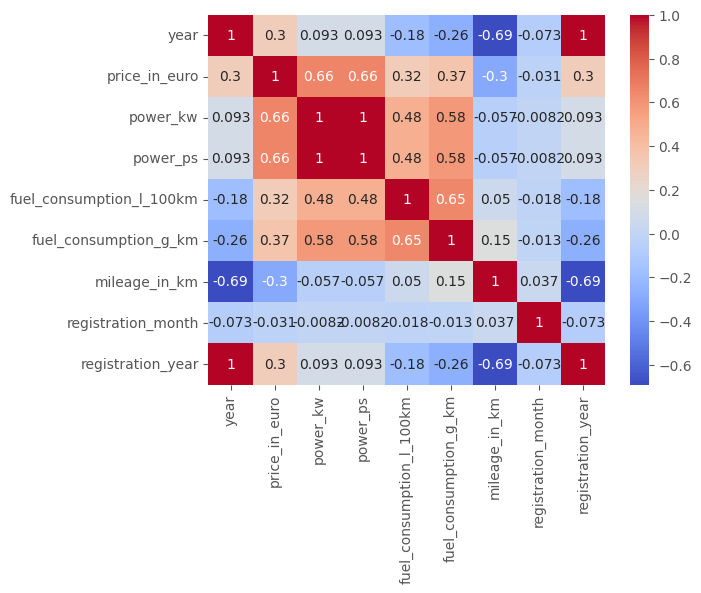

In [4]:
sns.heatmap(df[numeric].corr(), annot=True, cmap='coolwarm')
plt.show()

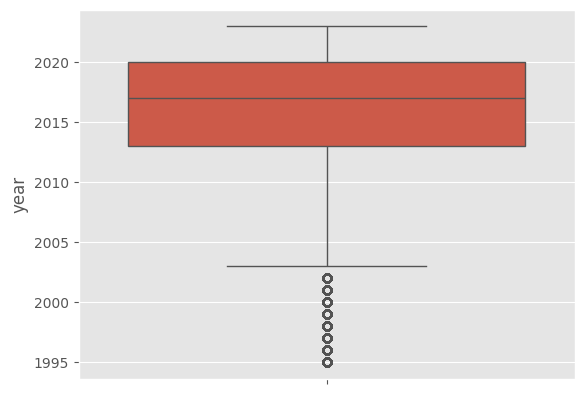

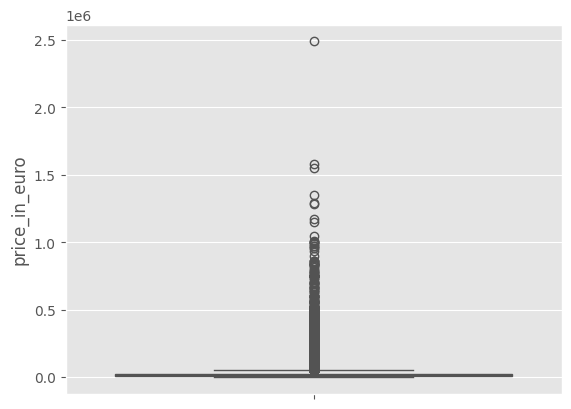

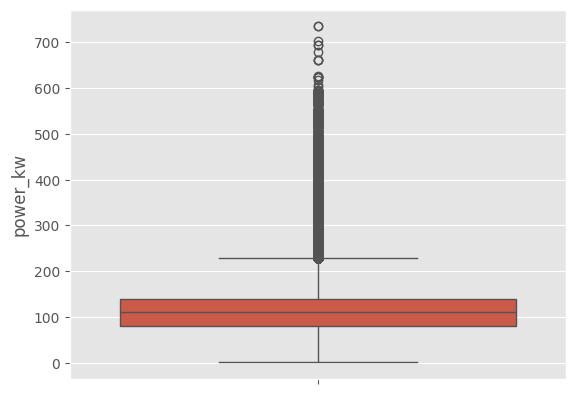

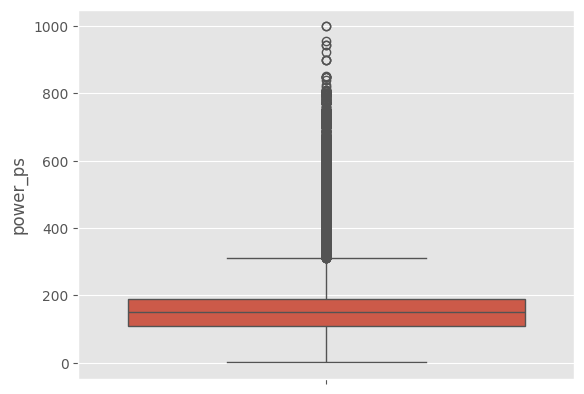

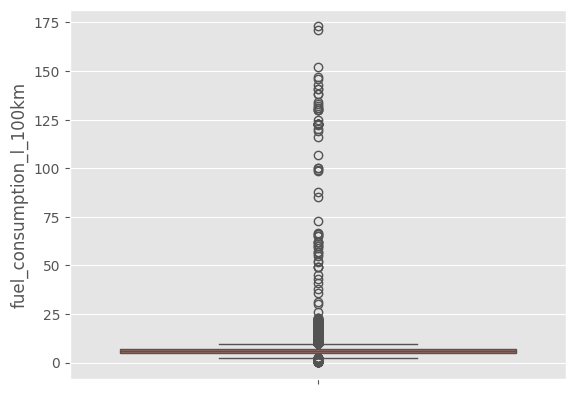

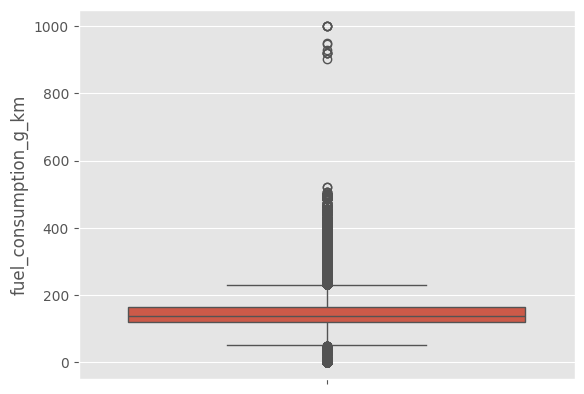

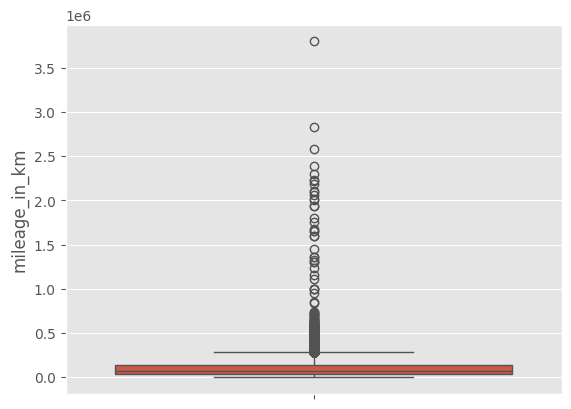

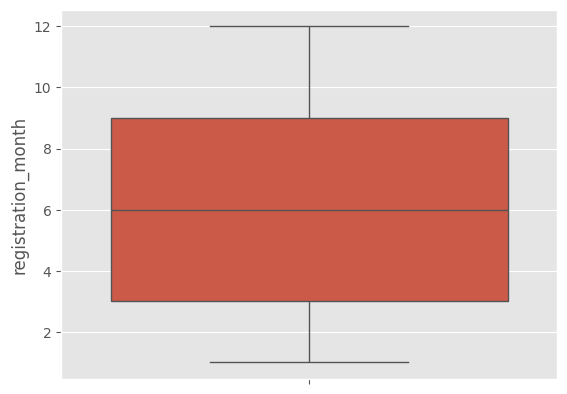

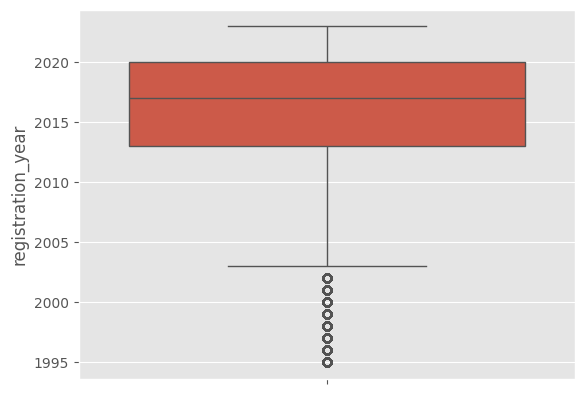

In [7]:
for feature in numeric:
    sns.boxplot(y= feature, data= df)
    plt.show()

In [8]:
df.columns

Index(['brand', 'model', 'color', 'registration_date', 'year', 'price_in_euro',
       'power_kw', 'power_ps', 'transmission_type', 'fuel_type',
       'fuel_consumption_l_100km', 'fuel_consumption_g_km', 'mileage_in_km',
       'offer_description', 'registration_month', 'registration_year'],
      dtype='object')

In [9]:
df.sort_values(by = 'fuel_consumption_l_100km', ascending= False)

,brand,model,color,registration_date,year,price_in_euro,power_kw,power_ps,transmission_type,fuel_type,fuel_consumption_l_100km,fuel_consumption_g_km,mileage_in_km,offer_description,registration_month,registration_year
165076,seat,SEAT Tarraco,grey,2020-08-01,2020,25690,110.0,150.0,Manual,Petrol,173.0,173.0,28400.0,1.5 Style TSI BMT 7 Sitze Navi Klima,8,2020
182661,skoda,Skoda Karoq,white,2023-04-01,2023,40790,140.0,190.0,Automatic,Petrol,171.0,171.0,10.0,2.0TSI DSG 4x4 Sportline Navi DCC Kamera,4,2023
119864,mini,MINI Cooper S,silver,2022-07-01,2022,27990,131.0,178.0,Automatic,Petrol,152.0,128.0,24000.0,"Cabrio Aut. Yours Trim, RFK, SHZ, Komfortzugan...",7,2022
165055,seat,SEAT Ateca,grey,2020-09-01,2020,21990,110.0,150.0,Manual,Diesel,147.0,147.0,29000.0,2.0 Style TDI BMT Klima Radio Alu,9,2020
212256,volkswagen,Volkswagen T-Roc,red,2019-03-01,2019,18990,85.0,116.0,Manual,Diesel,146.0,146.0,40800.0,1.6 Comfortline StyleTDI BMT Navi Klima,3,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222279,volvo,Volvo V60,grey,2022-05-01,2022,36980,145.0,197.0,Automatic,Diesel,NaN,0.0,14657.0,2.0 B4 D Inscription*Navi*LED*ACC*Kamera*,5,2022
222331,volvo,Volvo V60,black,2022-06-01,2022,39180,145.0,197.0,Automatic,Petrol,NaN,0.0,8443.0,2.0 B4 R-Design*Navi*ACC*LED*Kamera*Keyless,6,2022
222348,volvo,Volvo V60,black,2022-01-01,2022,32900,120.0,163.0,Automatic,Petrol,NaN,NaN,30468.0,B3 B DKG Momentum Pro,1,2022
222399,volvo,Volvo V90 Cross Country,black,2022-05-01,2022,59990,173.0,235.0,Automatic,Diesel,NaN,NaN,5502.0,Pro B5 D AWD Aut. Pano/HUD/Kamera,5,2022


In [ ]:
df[df['fuel_consumption_g_km'] == df['fuel_consumption_l_100km']].sort_values(by = 'fuel_consumption_l_100km', ascending= False)  

,brand,model,color,registration_date,year,price_in_euro,power_kw,power_ps,transmission_type,fuel_type,fuel_consumption_l_100km,fuel_consumption_g_km,mileage_in_km,offer_description,registration_month,registration_year
165076,seat,SEAT Tarraco,grey,2020-08-01,2020,25690,110.0,150.0,Manual,Petrol,173.0,173.0,28400.0,1.5 Style TSI BMT 7 Sitze Navi Klima,8,2020
182661,skoda,Skoda Karoq,white,2023-04-01,2023,40790,140.0,190.0,Automatic,Petrol,171.0,171.0,10.0,2.0TSI DSG 4x4 Sportline Navi DCC Kamera,4,2023
165055,seat,SEAT Ateca,grey,2020-09-01,2020,21990,110.0,150.0,Manual,Diesel,147.0,147.0,29000.0,2.0 Style TDI BMT Klima Radio Alu,9,2020
212256,volkswagen,Volkswagen T-Roc,red,2019-03-01,2019,18990,85.0,116.0,Manual,Diesel,146.0,146.0,40800.0,1.6 Comfortline StyleTDI BMT Navi Klima,3,2019
214491,volkswagen,Volkswagen Golf Variant,silver,2020-08-01,2020,22990,110.0,150.0,Automatic,Diesel,143.0,143.0,33600.0,2.0 United BMT TDI DSG Navi Klima,8,2020
165647,seat,SEAT Arona,silver,2020-05-01,2020,18990,85.0,116.0,Automatic,Petrol,138.0,138.0,21900.0,1.0 Style TSI BMT DSG Klima Navi Alu,5,2020
165626,seat,SEAT Arona,silver,2020-01-01,2020,18690,85.0,116.0,Automatic,Petrol,138.0,138.0,43900.0,1.0 Style TSI BMT DSG Klima Radio Alu,1,2020
165950,seat,SEAT Arona,white,2020-04-01,2020,21690,110.0,150.0,Manual,Petrol,134.0,134.0,21400.0,1.5 FR-Line TSI BMT Navi Klima Alu,4,2020
169290,seat,SEAT Arona,black,2023-03-01,2023,23900,81.0,110.0,Automatic,Petrol,133.0,133.0,1100.0,FR 1.0 TSI DSG NAVI KAMERA VIRTUAL LED FUL,3,2023
165142,seat,SEAT Arona,red,2020-03-01,2020,18690,85.0,116.0,Manual,Petrol,132.0,132.0,16300.0,1.5 FR-Line TSI BMT Klima Navi Alu,3,2020


In [21]:
df.query('fuel_consumption_l_100km > 30 & fuel_consumption_l_100km != fuel_consumption_g_km')

,brand,model,color,registration_date,year,price_in_euro,power_kw,power_ps,transmission_type,fuel_type,fuel_consumption_l_100km,fuel_consumption_g_km,mileage_in_km,offer_description,registration_month,registration_year
21638,bentley,Bentley Continental GT,brown,2016-08-01,2016,109999,434.0,590.0,Automatic,Petrol,141.000000,327.00,41500.0,Coupe W12 Niam Wifi,8,2016
27544,bmw,BMW 650,grey,2011-10-01,2011,17500,300.0,408.0,Automatic,Petrol,99.000000,249.00,200000.0,Coupe 650i Leder Xenon Head Up Pano 360 Kamera,10,2011
39878,bmw,BMW X7,black,2022-09-01,2022,111889,250.0,340.0,Automatic,Diesel,66.400000,167.00,11100.0,xDrive40d M Sport DrivePro NightVision SkyLo.,9,2022
40441,bmw,BMW 420,black,2023-05-01,2023,62560,135.0,184.0,Automatic,Petrol,73.000000,166.00,1000.0,i M Sportpaket HiFi DAB LED Komfortzg.,5,2023
41677,citroen,Citroen DS5,white,2015-11-01,2015,13944,88.0,120.0,Manual,Diesel,38.000000,100.00,63000.0,BlueHDi 120 EU6 -SUPER EXTRAS- *AUCH MIT GARAN...,11,2015
42369,citroen,Citroen C4 Cactus,white,2018-07-01,2018,15490,81.0,110.0,Manual,Petrol,45.000000,104.00,37409.0,1.2 Puretech 110 Sitzheizung Kamera,7,2018
46203,dacia,Dacia Dokker,red,2021-07-01,2021,20990,96.0,131.0,Manual,Petrol,62.000000,141.00,16155.0,Stepway Pro NAVI+CAM KLIMA PDC ALLWETTER,7,2021
53166,ford,Ford Tourneo Connect,white,2007-07-01,2007,3500,55.0,75.0,Manual,Diesel,65.000000,23.00,151000.0,Kasten mit LKW Zulassung Diesel,7,2007
54585,ford,Ford Focus,silver,2011-01-01,2011,3800,66.0,90.0,Manual,Diesel,66.000000,NaN,270000.0,Focus Turnier 1.6 TDCi DPF Concept,1,2011
63921,ford,Ford Focus,red,2019-11-01,2019,17990,88.0,120.0,Automatic,Diesel,99.900000,112.00,75353.0,Active 1.5 EcoBlue AT LED Navi Kam Pano,11,2019


In [22]:
df.query('model == "Bentley Continental GT"')

,brand,model,color,registration_date,year,price_in_euro,power_kw,power_ps,transmission_type,fuel_type,fuel_consumption_l_100km,fuel_consumption_g_km,mileage_in_km,offer_description,registration_month,registration_year
21493,bentley,Bentley Continental GT,green,2005-09-01,2005,57999,411.0,559.0,Automatic,Petrol,16.6,396.0,39000.0,C Mulliner in absolutem Neuzustand Spruce Green,9,2005
21496,bentley,Bentley Continental GT,black,2005-10-01,2005,54949,412.0,560.0,Automatic,Petrol,17.1,410.0,59000.0,Mansory GT 63 Unikat 22 Zoll TOP!,10,2005
21498,bentley,Bentley Continental GT,silver,2005-06-01,2005,35990,411.0,559.0,Automatic,Petrol,17.1,410.0,105990.0,6.0 W12|LEDER|MASSAGE|Keyless-Go|,6,2005
21504,bentley,Bentley Continental GT,white,2006-06-01,2006,48900,411.0,559.0,Automatic,Petrol,17.1,410.0,83900.0,MANSORY-UMBAU TOP,6,2006
21512,bentley,Bentley Continental GT,black,2007-05-01,2007,49999,411.0,559.0,Automatic,Petrol,17.1,410.0,54999.0,MANSORY-OPTIK*FACELIFT-UMBAU*,5,2007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21927,bentley,Bentley Continental GT,grey,2023-06-01,2023,299900,404.0,549.0,Automatic,Petrol,11.3,263.0,3600.0,V8 Azure // BENTLEY DÜSSELDORF,6,2023
21936,bentley,Bentley Continental GT,grey,2023-01-01,2023,274900,404.0,549.0,Automatic,Petrol,11.3,263.0,3985.0,V8 Azure // BENTLEY DÜSSELDORF,1,2023
21942,bentley,Bentley Continental GT,green,2023-04-01,2023,285500,405.0,551.0,Automatic,Petrol,11.3,263.0,3100.0,S V8 - MY23 - BENTLEY BERLIN -,4,2023
21943,bentley,Bentley Continental GT,green,2023-02-01,2023,285450,405.0,551.0,Automatic,Petrol,11.3,263.0,4000.0,V8 #On STOCK #,2,2023


In [31]:
df.query('fuel_consumption_l_100km > 22').sort_values(by = 'fuel_consumption_l_100km', ascending= True)

,brand,model,color,registration_date,year,price_in_euro,power_kw,power_ps,transmission_type,fuel_type,fuel_consumption_l_100km,fuel_consumption_g_km,mileage_in_km,offer_description,registration_month,registration_year
47516,ferrari,Ferrari 456,silver,2000-05-01,2000,62500,325.0,442.0,Automatic,Petrol,22.2,NaN,73590.0,456M GTA,5,2000
47502,ferrari,Ferrari 456,blue,1998-05-01,1998,90000,325.0,442.0,Automatic,Petrol,22.2,520.0,7500.0,GTA,5,1998
47507,ferrari,Ferrari 550,red,1999-01-01,1999,225000,357.0,485.0,Manual,Petrol,22.9,520.0,9260.0,Maranello,1,1999
47503,ferrari,Ferrari 550,grey,1998-04-01,1998,139550,357.0,485.0,Manual,Petrol,22.9,NaN,41500.0,Maranello Kofferset / Service neu / 3.Hand,4,1998
47515,ferrari,Ferrari 550,black,2000-07-01,2000,145550,357.0,485.0,Manual,Petrol,22.9,NaN,59752.0,M FIORANO/DAYTONA SEAT Deutsches Fahrzeug !,7,2000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212256,volkswagen,Volkswagen T-Roc,red,2019-03-01,2019,18990,85.0,116.0,Manual,Diesel,146.0,146.0,40800.0,1.6 Comfortline StyleTDI BMT Navi Klima,3,2019
165055,seat,SEAT Ateca,grey,2020-09-01,2020,21990,110.0,150.0,Manual,Diesel,147.0,147.0,29000.0,2.0 Style TDI BMT Klima Radio Alu,9,2020
119864,mini,MINI Cooper S,silver,2022-07-01,2022,27990,131.0,178.0,Automatic,Petrol,152.0,128.0,24000.0,"Cabrio Aut. Yours Trim, RFK, SHZ, Komfortzugan...",7,2022
182661,skoda,Skoda Karoq,white,2023-04-01,2023,40790,140.0,190.0,Automatic,Petrol,171.0,171.0,10.0,2.0TSI DSG 4x4 Sportline Navi DCC Kamera,4,2023


In [16]:
df_initial[(df_initial['model'] == 'SEAT Tarraco') & (df_initial['color'] == 'grey')]

df_initial.query('model == "SEAT Tarraco" & color == "grey" & year == "2020"')

,Unnamed: 0,brand,model,color,registration_date,year,price_in_euro,power_kw,power_ps,transmission_type,fuel_type,fuel_consumption_l_100km,fuel_consumption_g_km,mileage_in_km,offer_description
183677,183677,seat,SEAT Tarraco,grey,02/2020,2020,31991,140,190,Automatic,Petrol,"7,3 l/100 km",166 g/km,49500.0,Xcellence 4Drive*20ZOLL*ACC*AHK*STHZ*SHZ
183679,183679,seat,SEAT Tarraco,grey,01/2020,2020,31400,140,190,Automatic,Petrol,"7,3 l/100 km",192 g/km,59000.0,2.0 TSI 4Drive DSG Xcellence FullLink/AC
183684,183684,seat,SEAT Tarraco,grey,05/2020,2020,34750,140,190,Automatic,Diesel,"5,6 l/100 km",147 g/km,34820.0,2.0 TDI 4x4 DSG Xcellence 7-Sitzer AHK Navi+VC...
183691,183691,seat,SEAT Tarraco,grey,04/2020,2020,35480,140,190,Automatic,Diesel,"5,6 l/100 km",147 g/km,39100.0,Xcellence 2.0 TDI 4Drive LED PANO KAM
183707,183707,seat,SEAT Tarraco,grey,02/2020,2020,27330,110,150,Manual,Diesel,"4,9 l/100 km",155 g/km,39370.0,Style 2.0 TDI AHK-Vorb./LED/ACC/Nav/Pano
183713,183713,seat,SEAT Tarraco,grey,05/2020,2020,33990,140,190,Automatic,Petrol,"7,3 l/100 km",166 g/km,55780.0,2.0 TSI Xcellence 4Drive LED Navi Kamera
183721,183721,seat,SEAT Tarraco,grey,03/2020,2020,28190,110,150,Manual,Diesel,NaN,- (g/km),59190.0,"Xcellence 2.0 TDI - NAVI,LED,PDC,ACC,DAB"
183727,183727,seat,SEAT Tarraco,grey,07/2020,2020,31940,140,190,Automatic,Petrol,"7,3 l/100 km",166 g/km,74610.0,Xcellence 4M Kamera Leder Virtual 7 Sitz
183738,183738,seat,SEAT Tarraco,grey,02/2020,2020,31990,110,150,Automatic,Diesel,"5,6 l/100 km",146 g/km,49900.0,Style 4Drive 2.0 TDI DSG LED ACC Virtual
183742,183742,seat,SEAT Tarraco,grey,02/2020,2020,29350,110,150,Automatic,Diesel,"5,6 l/100 km",146 g/km,99400.0,"Xcell 4D 2,0 TDI SCR Navi LED Leder Kamera ACC..."
